In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 895 kB 50.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 290 kB 4.3 MB/s 
     |████████████████████████████████| 243 kB 42.8 MB/s 
     |████████████████████████████████| 1.3 MB 41.0 MB/s 
     |████████████████████████████████| 125 kB 51.1 MB/s 
     |████████████████████████████████| 160 kB 47.8 MB/s 
     |████████████████████████████████| 271 kB 47.8 MB/s 
     |████████████████████████████████| 123 kB 3.9 MB/s 
     |████████████████████████████████| 131 kB 37.1 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 8.0 MB

In [5]:
import os
import json
import pandas as pd

In [8]:
from datasets import load_dataset
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="/content/drive/My Drive/Colab Notebooks" )

Using custom data configuration en-bf77df60ed1db41e


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-bf77df60ed1db41e/1.0.0/61d5d736f7a6a127fff0ac0182263d45c2e2192a6af6c4459f2d4a3d22083ef4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
cd_df = covid_dialog['train'].to_pandas()
cd_df.head()

In [12]:
print(cd_df["dialogue_turns"])
print(cd_df["dialogue_turns"][0])

0      {'speaker': [0, 1, 0, 1], 'utterance': ['I hav...
1      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran...
2      {'speaker': [0, 1], 'utterance': ['Can Coronav...
3      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
4      {'speaker': [0, 1], 'utterance': ['Does COVID-...
                             ...                        
567    {'speaker': [0, 1], 'utterance': ['If I get co...
568    {'speaker': [0, 1], 'utterance': ['I was on a ...
569    {'speaker': [0, 1], 'utterance': ['My son has ...
570    {'speaker': [0, 1], 'utterance': ['Can coronav...
571    {'speaker': [0, 1], 'utterance': ['Good day,  ...
Name: dialogue_turns, Length: 572, dtype: object
{'speaker': array([0, 1, 0, 1]), 'utterance': array(['I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been f

In [ ]:
# We may want to parse all doctor, patient pairs and use that instead
# We also may want to consider truncating on the left (context) side
# Right now we are just generating text, there is no 
# text_to_answer = []
# for dial in cd_df["dialogue_turns"]:
#   u = dial["utterance"]
#   q = u[0]
#   a, u = u[-1], u[0:-1]
#   text_to_answer.append(['<|endoftext|>'.join(u), a])
# qa_df = pd.DataFrame(text_to_answer, columns=["text","answer"])

In [13]:
# Here we have only text 
text = []
for dial in cd_df["dialogue_turns"]:
  u = dial["utterance"]
  # text.append(['<|endoftext|>'.join(u)])
  text.append([''.join(u)])
qa_df = pd.DataFrame(text, columns=["text"])

In [14]:
qa_df["text"][0]

'I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help.Hello, I understand your concern. I just have a few more questions.Does your cough has phlegm? Any other symptoms like difficulty breathing? Any other medical condition such as asthma, hypertension? Are you a smoker? Alcoholic beverage drinker?Thank you doctor,I have phlegm but not a lot. A tiny amount comes out most of the time. I have no difficulty in breathing. No medical conditions and not a smoker nor a drinker.Hi, I would recommend you take n-acetylcysteine 200 mg powder dissolved in water three times a day. You may also nebulize using PNSS (saline nebulizer) three times a day.

In [15]:
print(qa_df)

                                                  text
0    I have cough with no travel history. Is this a...
1    I have a little fever with no history of forei...
2    Can Coronavirus cause itchiness in throat and ...
3    I have chills, breathing problems and cough wi...
4    Does COVID-19 spreads through water? What prec...
..                                                 ...
567  If I get coronavirus, are there ways to avoid ...
568  I was on a plane on March 8th have been home e...
569  My son has a fever, I am concerned due to the ...
570  Can coronavirus symptoms be mild for some peop...
571  Good day,  I am 29 weeks pregnant and my profe...

[572 rows x 1 columns]


In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP
from budgie import BudgieNet

In [17]:
"""
Types
transformer_outputs => BaseModelOutputWithPastAndCrossAttentions
model => GPT2LMHeadModel 
"""

'\nTypes\ntransformer_outputs => BaseModelOutputWithPastAndCrossAttentions\nmodel => GPT2LMHeadModel \n'

In [18]:
"""
There is currently a bug in the implementation which results 
in zero loss for the zero reward values. This must be re-evaluated
"""

'\nThere is currently a bug in the implementation which results \nin zero loss for the zero reward values. This must be re-evaluated\n'

In [29]:
model = BudgieNet.from_pretrained("microsoft/DialoGPT-small", output_hidden_states = True)
dtokenizer = GPT2TokenizerFast.from_pretrained("microsoft/DialoGPT-small")
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of BudgieNet were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['interesting_head.decoder.weight', 'funny_head.decoder.weight', 'choosing_head.bias', 'choosing_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
tokenizer.save_pretrained("./tokenizer") 
dtokenizer.save_pretrained("./dtokenizer") 

('./dtokenizer/tokenizer_config.json',
 './dtokenizer/special_tokens_map.json',
 './dtokenizer/vocab.json',
 './dtokenizer/merges.txt',
 './dtokenizer/added_tokens.json',
 './dtokenizer/tokenizer.json')

In [23]:
vocab_dict = {}
cnt = 0
with open('./tokenizer/vocab.txt') as tfile:
  for line in tfile:
    l = line.rstrip()
    vocab_dict[cnt] = l
    cnt += 1

print(cnt)

58996


In [ ]:
vocab_dict

In [26]:
json1 = json.load(open('./dtokenizer/vocab.json'))
# json2 = json.load(open('./tokenizer/vocab.json'))
# Use the vocab_dict here??

In [27]:
string = "covid"
cough_token_bert = tokenizer(string)
cough_token_gpt = dtokenizer(string)
cb = cough_token_bert["input_ids"]
gp = cough_token_gpt["input_ids"]
# print(cough_token_gpt)
# print(cb)
# print(gp)
tokens_cb = tokenizer.convert_ids_to_tokens(cb)
tokens_gp = dtokenizer.convert_ids_to_tokens(gp)
print(f"GPT2 tokenizes {string} as : \n")
for i in range(len(gp)):
  tokens_gp = dtokenizer.convert_ids_to_tokens(gp[i])
  print(dtokenizer.convert_tokens_to_string(tokens_gp))
print(f"BioBert tokenizes {string} as : \n")
for j in range(len(cb)):
  tokens_cb = tokenizer.convert_ids_to_tokens(cb[j])
  print(tokenizer.convert_tokens_to_string(tokens_cb))

GPT2 tokenizes covid as : 

c
ov
id
BioBert tokenizes covid as : 

[ C L S ]
c o v
# # i d
[ S E P ]


In [30]:
# https://huggingface.co/transformers/main_classes/model.html
input_embs = model.get_input_embeddings()
output_embs = model.get_output_embeddings()


string1 = "I am headed to the bank to fish" + tokenizer.eos_token
string2 = "I am headed to the bank to get a loan" + tokenizer.eos_token
dog = "dog"
tokens1 = tokenizer.tokenize(string1)
tokens2 = tokenizer.tokenize(string2)
dog_tokens = tokenizer.tokenize(dog)
print(tokens1)
print(tokens2)
# print(dog_tokens)
ids1 = tokenizer(string1)['input_ids']
ids2 = tokenizer(string2)['input_ids']
ids3 = tokenizer(dog)['input_ids']
# print(ids1)
# print(ids2)
# print(ids3)
states1 = input_embs(torch.tensor(ids1, dtype=int))
states2 = input_embs(torch.tensor(ids2, dtype=int))
states3 = input_embs(torch.tensor(ids3, dtype=int))
print(states1[-2][0:5])
print(states2[-2][0:5])
# print(states2)
# print(states3)
word = output_embs(states)
tops = torch.topk(word, 20).indices
print(tops)
tokens = tokenizer.convert_ids_to_tokens(tops)
strings = tokenizer.convert_tokens_to_string(tokens)
print(strings)
# Convert string to sequence of tokens (WRONG)
# word = tokenizer.decode(14231)
# print(word)
# id = tokenizer.convert_tokens_to_ids(token)
# string = tokenizer.convert_tokens_to_string(token)
# token = tokenizer.convert_ids_to_tokens(id)


# print(id, token,string)

Using eos_token, but it is not set yet.


TypeError: ignored

In [31]:
step = 0
model.playmode = True

while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, return_dict=True, pad_token_id=tokenizer.eos_token_id)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: 白alp
>> User:1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: 白alp
>> User:0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: 白alp
>> User:1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: 白alp


KeyboardInterrupt: ignored

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = AdamW(model.parameters(), lr=5e-5)

In [33]:
response_map = {1: "funny", 0:"interesting"}

In [34]:
model.reset_state()
model.index = 0
while model.index < 100:
    while not (model.index % (model.batch_size + 1)) == 0:
        context = input(">> User:")
        # encode the new user input, add the eos_token and return a tensor in Pytorch
        new_user_input_ids = tokenizer(context + tokenizer.eos_token, return_tensors='pt').input_ids

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if model.index > 1 else new_user_input_ids
        output = model(bot_input_ids)
        token_vecs = output.hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        model.choose(sentence_embedding)
        model.start_generation()
        # average the second to last hiden layer of each token to get sentence rep

        # generated a response while limiting the total chat history to 1000 tokens, 
        chat_history_ids = model.generate(bot_input_ids, max_length=1000, return_dict=True, pad_token_id=tokenizer.eos_token_id)
        model.stop_generation()
        model.combine_logits()
        # pretty print last ouput tokens from bot
        print(chat_history_ids[:, bot_input_ids.shape[-1]:])
        print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
        model.increment()
        social = input(f">> Should I have been {response_map[model.choice]} here ? - if not leave blank and enter")
        model.affirm_social(len(social))
        accurate = input(f">> Was this actually {response_map[model.choice]} ? - how much so 0-5 ")
        accurate = int(accurate) if len(accurate) else 0
        model.affirm_reward(accurate)

    if model.index != 0:
        print("Training the model")
        optim.zero_grad()
        loss = model.calculate_total_loss()
        model.reset_state()
        print(loss)
        loss.backward()
        optim.step()
    model.increment()


>> User:1


Using eos_token, but it is not set yet.


TypeError: ignored

In [35]:
qa_df

,text
0,I have cough with no travel history. Is this a...
1,I have a little fever with no history of forei...
2,Can Coronavirus cause itchiness in throat and ...
3,"I have chills, breathing problems and cough wi..."
4,Does COVID-19 spreads through water? What prec...
...,...
567,"If I get coronavirus, are there ways to avoid ..."
568,I was on a plane on March 8th have been home e...
569,"My son has a fever, I am concerned due to the ..."
570,Can coronavirus symptoms be mild for some peop...


In [36]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
text = qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


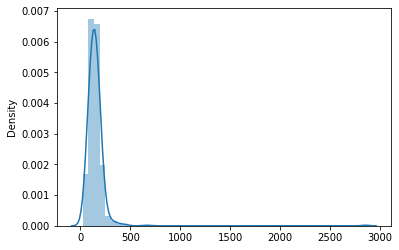

In [38]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [39]:
torch.cuda.empty_cache()

In [40]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


In [41]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [42]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  514 training samples
   58 validation samples


In [43]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [44]:
useCuda = True

In [45]:
print(device)

cuda


In [46]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [47]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [48]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [49]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [50]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

In [51]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.8707444071769714.   Elapsed: 0:01:43.
0: In brief:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.6641737222671509.   Elapsed: 0:03:25.
0: ?

  Average training loss: 1.11
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.9480767250061035.   Elapsed: 0:01:42.
0: ?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.4234502613544464.   Elapsed: 0:03:24.
0: ,,,?

  Average training loss: 0.64
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 0.60
  Validation took: 0:00:09

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.3019571006298065.   Elapsed: 0:01:42.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.7944352626800537.   Elapsed: 0:03:24.
0: 

  Average training loss: 0.52
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 0.59
  Validation took: 0:00:09

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.34279292821884155.   Elapsed: 0:01:42.
0: .


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.5258026123046875.   Elapsed: 0:03:24.
0: ,.

  Average training loss: 0.43
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 0.61
  Validation took: 0:00:09

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.42358195781707764.   Elapsed: 0:01:42.
0: ,,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.42286768555641174.   Elapsed: 0:03:23.
0: ,.

  Average training loss: 0.35
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 0.64
  Validation took: 0:00:09

Training complete!
Total training took 0:22:34 (h:mm:ss)


In [52]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.11,0.64,0:04:22,0:00:09
2,0.64,0.60,0:04:21,0:00:09
3,0.52,0.59,0:04:21,0:00:09
4,0.43,0.61,0:04:21,0:00:09
5,0.35,0.64,0:04:21,0:00:09


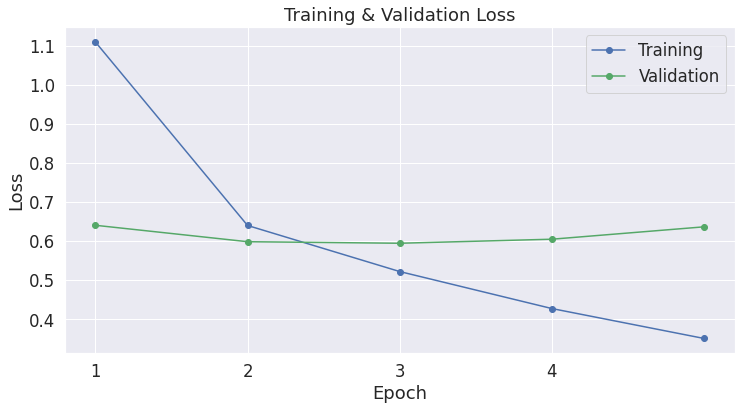

In [53]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [54]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [55]:
step = 0
# model.playmode = True
model = model.to('cpu')
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

>> User:1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT:  have been coughing and sneezing for the past week and a half, I have been feeling dizzy and short of breath for the past two days. I have been coughing and sneezing for the past two days and a half, I have been feeling dizzy and short of breath for the past two days. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days and a half. I have been feeling dizzy and short of breath for the past two days. I have been 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: .
>> User:0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: .


KeyboardInterrupt: ignored

In [56]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

cpu
cpu


In [57]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')